In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
import pandas as pd
import numpy as np

# Feature Selection Packages
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector as SFS

# Plotting Tools
import matplotlib.pyplot as plt
import seaborn as sns
# Plotly plotting package
import plotly.graph_objects as go
import plotly.express as px


# All Models
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DTC, plot_tree
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from sklearn.ensemble import GradientBoostingClassifier as GDBoost
from sklearn.svm import SVC
from xgboost import XGBClassifier as XGBC

# Tools in sklearn to select best model
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

# We use f1 score to test


# Model performance evaluation: AUROC and average precision (AP) scores and f1 score from sklearn
from sklearn.metrics import roc_auc_score, average_precision_score,accuracy_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import f1_score

In [3]:
input = pd.read_csv("/content/drive/My Drive/Colab Notebooks/sph6004_assignment1_data.csv")

# Data preprocessing & Preliminary Feature Selection

### Dealing with Missing Values

In [4]:
input.shape

(50920, 162)

In [5]:
df = input
pd.concat([df.min(),df.max()],axis=1)

0                1
id                                  30000153         39999810
aki                                        0                3
gender                                     F                M
admission_age                      18.002527       102.865603
race           AMERICAN INDIAN/ALASKA NATIVE  WHITE - RUSSIAN
...                                      ...              ...
gcs_verbal                               0.0              5.0
gcs_eyes                                 1.0              4.0
gcs_unable                               0.0              1.0
height                                 122.0            226.0
weight_admit                             1.0           5864.0

[162 rows x 2 columns]

In [6]:
df.loc[(df['weight_admit'] > 300) | (df['weight_admit'] < 30), 'weight_admit']= np.nan

In [7]:
df.loc[(df['weight_admit'] > 300) | (df['weight_admit'] < 30), 'weight_admit']

Series([], Name: weight_admit, dtype: float64)

In [8]:
df.loc[:,'weight_admit'].max()

296.8

Text(0.5, 0, 'Percentage of Missing Values per Sample')

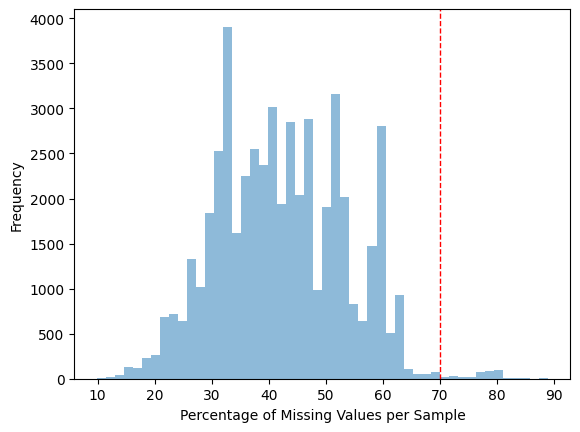

In [9]:
# Examine whether there are outlier patients with significant amount of missing data
# Many samples has a lot of missing data. Does not make sense to remove such a significant portion of the data

percent_missing = df.isnull().sum(axis = 1) * 100 / len(df.columns)

missing_value_df = pd.DataFrame({'row_names': df.index,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df.iloc[1:10,:]
missing_value_df.iloc[-10:-1,:]
p = missing_value_df.loc[:,'percent_missing'].plot.hist(bins=50, alpha=0.5)
p.axvline(70,color='red', linestyle='dashed', linewidth=1)
p.set_xlabel('Percentage of Missing Values per Sample')

In [10]:
# Feature Selection 1: remove features with too many missing values
# Remove outlier: Drop patient samples with more than 70% missing values
df = df.dropna(axis=0, thresh = len(df.columns)*0.3)

In [11]:
df.shape

(50552, 162)

Text(0.5, 0, 'Percentage of Missing Values per Feature')

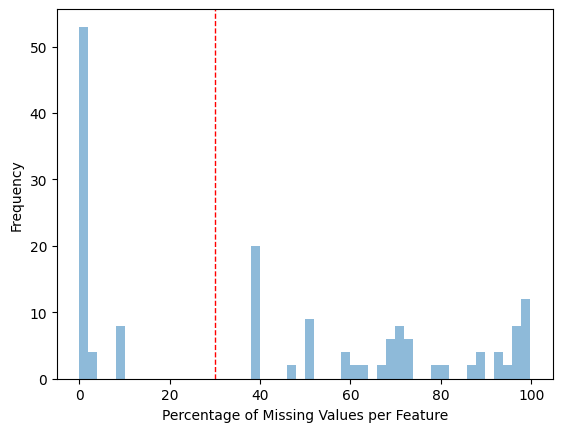

In [12]:
# examine missing values for each feature
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df
p = missing_value_df.loc[:,'percent_missing'].plot.hist(bins=50, alpha=0.5)
p.axvline(30,color='red', linestyle='dashed', linewidth=1)
p.set_xlabel('Percentage of Missing Values per Feature')
# all <10% missing, no need to remove features, proceed to impute missing values

In [13]:
# drop columns with more than 20% missing data: remove features with too many missing values
df = df.dropna(axis=1, thresh = len(df)*0.8)
df

id  aki gender  admission_age                    race  \
0      36570066    3      F      79.953141  BLACK/AFRICAN AMERICAN   
1      39307659    0      F      78.194169         WHITE - RUSSIAN   
2      38743306    2      F      65.602396                   WHITE   
3      32339865    2      F      64.906629                 UNKNOWN   
4      35526987    2      M      57.438861                   WHITE   
...         ...  ...    ...            ...                     ...   
50915  33431859    0      M      66.174854                   WHITE   
50916  38881410    2      F      57.033913                   WHITE   
50917  31061555    0      F      55.399450                   WHITE   
50918  32355547    3      F      66.058622              PORTUGUESE   
50919  38115934    2      M      51.528130                 UNKNOWN   

       heart_rate_min  heart_rate_max  heart_rate_mean  sbp_min  sbp_max  ...  \
0                96.0           104.0       100.083333    103.0    126.0  ...   
1                72.0           134.0        97.263158     97.0    127.0  ...   
2                60.0            97.0        84.166667     95.0    143.0  ...   
3                59.0            87.0        71.461538    113.0    150.0  ...   
4                57.0           100.0        82.387097     81.0    127.0  ...   
...               ...             ...              ...      ...      ...  ...   
50915            46.0           104.0        84.652174     99.0    162.0  ...   
50916            94.0           112.0       102.040000     89.0    108.0  ...   
50917            68.0           162.0        91.666667     83.0    132.0  ...   
50918            58.0            82.0        65.076923     92.0    152.0  ...   
50919            84.0           130.0       105.391304     86.0    180.0  ...   

       pt_min  pt_max  ptt_min  ptt_max  gcs_min  gcs_motor  gcs_verbal  \
0        11.9    12.0     28.6     29.5     15.0        6.0         5.0   
1        20.0    24.7     28.4    150.0     15.0        6.0         5.0   
2        12.1    12.1     26.0     26.0     15.0        6.0         5.0   
3        12.8    12.8     26.1     26.1     15.0        1.0         0.0   
4        10.4    11.9     27.7     39.4     15.0        NaN         0.0   
...       ...     ...      ...      ...      ...        ...         ...   
50915    12.3    12.3     29.8     29.8     13.0        6.0         3.0   
50916     NaN     NaN      NaN      NaN     15.0        6.0         0.0   
50917     9.6    10.0     26.0     26.1      3.0        1.0         1.0   
50918    15.9    15.9     20.3     20.3     14.0        6.0         5.0   
50919    12.5    13.7     31.7     33.0     15.0        1.0         0.0   

       gcs_eyes  gcs_unable  weight_admit  
0           4.0         0.0         110.0  
1           4.0         0.0          82.0  
2           4.0         0.0          62.1  
3           1.0         1.0         113.1  
4           1.0         1.0          97.4  
...         ...         ...           ...  
50915       4.0         0.0         107.7  
50916       2.0         1.0          44.2  
50917       1.0         0.0          80.0  
50918       3.0         0.0          95.1  
50919       1.0         1.0          90.4  

[50552 rows x 65 columns]

In [14]:
pd.set_option('display.max_rows', 170)
for col in df.columns:
    print(col)

# DOI: 10.1007/s11255-023-03646-6 & MSD Manual

# heart rate: YES
# sbp: systolic bp
# dbp: diastolic bp
# mbp:
# resp
# temperature
# spo2
# glucose
# hematocrit
# hemoglobin
# platelet
# wbc
# aniongap
# bicarbonate
# bun: YES
# calcium: YES
# chloride:
# glucose.2
# sodium: yes
# potassium
# inr : international normalized ratio, time for blood to clot YES
# pt: prothrombin time YES
# ptt: partial thromboplastin time YES
# gcs: Glasgow Coma Scale, describe the extent of impaired consciousness in all types of acute medical and trauma patients.
# weight_admit

#ADD?:
# bilirubin_total_min.max,
# total_protein_min/max


id
aki
gender
admission_age
race
heart_rate_min
heart_rate_max
heart_rate_mean
sbp_min
sbp_max
sbp_mean
dbp_min
dbp_max
dbp_mean
mbp_min
mbp_max
mbp_mean
resp_rate_min
resp_rate_max
resp_rate_mean
temperature_min
temperature_max
temperature_mean
spo2_min
spo2_max
spo2_mean
glucose_min
glucose_max
glucose_mean
hematocrit_min.1
hematocrit_max.1
hemoglobin_min.1
hemoglobin_max.1
platelets_min
platelets_max
wbc_min
wbc_max
aniongap_min
aniongap_max
bicarbonate_min.1
bicarbonate_max.1
bun_min
bun_max
calcium_min.1
calcium_max.1
chloride_min.1
chloride_max.1
glucose_min.2
glucose_max.2
sodium_min.1
sodium_max.1
potassium_min.1
potassium_max.1
inr_min
inr_max
pt_min
pt_max
ptt_min
ptt_max
gcs_min
gcs_motor
gcs_verbal
gcs_eyes
gcs_unable
weight_admit


In [15]:
#from sklearn.datasets import make_classification
#X, y = make_classification(n_samples=100, n_features=20, n_informative=2)

In [16]:
# repeated measure for glucose, take average.
#df.loc[:,"glucose_min.avg"] = 1/3*(df.loc[:,"glucose_min"]+df.loc[:,"glucose_min.2"])
#df.loc[:,"glucose_max.avg"] = 1/3*(df.loc[:,"glucose_max"]+df.loc[:,"glucose_max.2"])
#df.loc[:,["glucose_min","glucose_max","glucose_min.2","glucose_max.2","glucose_min.avg","glucose_max.avg"]]
#df = df.drop(labels = ["glucose_min","glucose_max","glucose_min.2","glucose_max.2"], axis = 1)

In [17]:
df

id  aki gender  admission_age                    race  \
0      36570066    3      F      79.953141  BLACK/AFRICAN AMERICAN   
1      39307659    0      F      78.194169         WHITE - RUSSIAN   
2      38743306    2      F      65.602396                   WHITE   
3      32339865    2      F      64.906629                 UNKNOWN   
4      35526987    2      M      57.438861                   WHITE   
...         ...  ...    ...            ...                     ...   
50915  33431859    0      M      66.174854                   WHITE   
50916  38881410    2      F      57.033913                   WHITE   
50917  31061555    0      F      55.399450                   WHITE   
50918  32355547    3      F      66.058622              PORTUGUESE   
50919  38115934    2      M      51.528130                 UNKNOWN   

       heart_rate_min  heart_rate_max  heart_rate_mean  sbp_min  sbp_max  ...  \
0                96.0           104.0       100.083333    103.0    126.0  ...   
1                72.0           134.0        97.263158     97.0    127.0  ...   
2                60.0            97.0        84.166667     95.0    143.0  ...   
3                59.0            87.0        71.461538    113.0    150.0  ...   
4                57.0           100.0        82.387097     81.0    127.0  ...   
...               ...             ...              ...      ...      ...  ...   
50915            46.0           104.0        84.652174     99.0    162.0  ...   
50916            94.0           112.0       102.040000     89.0    108.0  ...   
50917            68.0           162.0        91.666667     83.0    132.0  ...   
50918            58.0            82.0        65.076923     92.0    152.0  ...   
50919            84.0           130.0       105.391304     86.0    180.0  ...   

       pt_min  pt_max  ptt_min  ptt_max  gcs_min  gcs_motor  gcs_verbal  \
0        11.9    12.0     28.6     29.5     15.0        6.0         5.0   
1        20.0    24.7     28.4    150.0     15.0        6.0         5.0   
2        12.1    12.1     26.0     26.0     15.0        6.0         5.0   
3        12.8    12.8     26.1     26.1     15.0        1.0         0.0   
4        10.4    11.9     27.7     39.4     15.0        NaN         0.0   
...       ...     ...      ...      ...      ...        ...         ...   
50915    12.3    12.3     29.8     29.8     13.0        6.0         3.0   
50916     NaN     NaN      NaN      NaN     15.0        6.0         0.0   
50917     9.6    10.0     26.0     26.1      3.0        1.0         1.0   
50918    15.9    15.9     20.3     20.3     14.0        6.0         5.0   
50919    12.5    13.7     31.7     33.0     15.0        1.0         0.0   

       gcs_eyes  gcs_unable  weight_admit  
0           4.0         0.0         110.0  
1           4.0         0.0          82.0  
2           4.0         0.0          62.1  
3           1.0         1.0         113.1  
4           1.0         1.0          97.4  
...         ...         ...           ...  
50915       4.0         0.0         107.7  
50916       2.0         1.0          44.2  
50917       1.0         0.0          80.0  
50918       3.0         0.0          95.1  
50919       1.0         1.0          90.4  

[50552 rows x 65 columns]

### Perform Imputation

In [18]:
X_toImpute =  df.drop(labels = ["aki",'id','gender','race'], axis = 1)

In [19]:
# Univariate Feature Imputation
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_toImpute)
X_imputed = imp.transform(X_toImpute)

In [20]:
X_imputed.shape

(50552, 61)

In [21]:
X_raw = pd.DataFrame(X_imputed, columns=X_toImpute.columns)
X_raw

admission_age  heart_rate_min  heart_rate_max  heart_rate_mean  \
0          79.953141            96.0           104.0       100.083333   
1          78.194169            72.0           134.0        97.263158   
2          65.602396            60.0            97.0        84.166667   
3          64.906629            59.0            87.0        71.461538   
4          57.438861            57.0           100.0        82.387097   
...              ...             ...             ...              ...   
50547      66.174854            46.0           104.0        84.652174   
50548      57.033913            94.0           112.0       102.040000   
50549      55.399450            68.0           162.0        91.666667   
50550      66.058622            58.0            82.0        65.076923   
50551      51.528130            84.0           130.0       105.391304   

       sbp_min  sbp_max    sbp_mean  dbp_min  dbp_max   dbp_mean  ...  \
0        103.0    126.0  116.136364     40.0     58.0  47.863636  ...   
1         97.0    127.0  109.833333     56.0     89.0  70.166667  ...   
2         95.0    143.0  112.153846     56.0     99.0  73.307692  ...   
3        113.0    150.0  138.160000     60.0     94.0  80.200000  ...   
4         81.0    127.0   97.672131     47.0     95.0  61.827869  ...   
...        ...      ...         ...      ...      ...        ...  ...   
50547     99.0    162.0  130.038462     52.0    114.0  73.846154  ...   
50548     89.0    108.0   97.500000     54.0     78.0  62.038462  ...   
50549     83.0    132.0  113.000000     43.0     86.0  65.000000  ...   
50550     92.0    152.0  112.916667     48.0     99.0  60.791667  ...   
50551     86.0    180.0  114.391304     54.0     92.0  63.869565  ...   

          pt_min     pt_max    ptt_min     ptt_max  gcs_min  gcs_motor  \
0      11.900000  12.000000  28.600000   29.500000     15.0   6.000000   
1      20.000000  24.700000  28.400000  150.000000     15.0   6.000000   
2      12.100000  12.100000  26.000000   26.000000     15.0   6.000000   
3      12.800000  12.800000  26.100000   26.100000     15.0   1.000000   
4      10.400000  11.900000  27.700000   39.400000     15.0   5.166536   
...          ...        ...        ...         ...      ...        ...   
50547  12.300000  12.300000  29.800000   29.800000     13.0   6.000000   
50548  14.337377  16.587468  31.077414   42.126171     15.0   6.000000   
50549   9.600000  10.000000  26.000000   26.100000      3.0   1.000000   
50550  15.900000  15.900000  20.300000   20.300000     14.0   6.000000   
50551  12.500000  13.700000  31.700000   33.000000     15.0   1.000000   

       gcs_verbal  gcs_eyes  gcs_unable  weight_admit  
0             5.0       4.0         0.0         110.0  
1             5.0       4.0         0.0          82.0  
2             5.0       4.0         0.0          62.1  
3             0.0       1.0         1.0         113.1  
4             0.0       1.0         1.0          97.4  
...           ...       ...         ...           ...  
50547         3.0       4.0         0.0         107.7  
50548         0.0       2.0         1.0          44.2  
50549         1.0       1.0         0.0          80.0  
50550         5.0       3.0         0.0          95.1  
50551         0.0       1.0         1.0          90.4  

[50552 rows x 61 columns]

In [22]:
# Normalize original data first.
X_df = (X_raw-X_raw.mean())/X_raw.std()
X_df

admission_age  heart_rate_min  heart_rate_max  heart_rate_mean  \
0           0.868310        1.725706        0.072188         1.006342   
1           0.766356        0.137659        1.539016         0.826706   
2           0.036513       -0.656364       -0.270072        -0.007496   
3          -0.003815       -0.722533       -0.759014        -0.816770   
4          -0.436661       -0.854870       -0.123389        -0.120849   
...              ...             ...             ...              ...   
50547       0.069694       -1.582725        0.072188         0.023429   
50548      -0.460133        1.593368        0.463342         1.130975   
50549      -0.554869       -0.127015        2.908055         0.470229   
50550       0.062957       -0.788702       -1.003486        -1.223448   
50551      -0.779258        0.931682        1.343439         1.344442   

        sbp_min   sbp_max  sbp_mean   dbp_min   dbp_max  dbp_mean  ...  \
0      0.560683 -0.980157 -0.179859 -0.623764 -1.545383 -1.419018  ...   
1      0.217582 -0.936097 -0.565724  0.743867  0.032966  0.561199  ...   
2      0.103215 -0.231130 -0.423665  0.743867  0.542110  0.840081  ...   
3      1.132517  0.077293  1.168403  1.085775  0.287538  1.452028  ...   
4     -0.697352 -0.936097 -1.310219 -0.025425  0.338452 -0.179177  ...   
...         ...       ...       ...       ...       ...       ...  ...   
50547  0.331949  0.606018  0.671212  0.401959  1.305827  0.887890  ...   
50548 -0.239885 -1.773245 -1.320757  0.572913 -0.527094 -0.160479  ...   
50549 -0.582986 -0.715795 -0.371864 -0.367333 -0.119778  0.102467  ...   
50550 -0.068335  0.165414 -0.376966  0.060051  0.542110 -0.271178  ...   
50551 -0.411435  1.399106 -0.286690  0.572913  0.185709  0.002099  ...   

             pt_min        pt_max       ptt_min   ptt_max   gcs_min  \
0     -4.447216e-01 -4.580966e-01 -2.202604e-01 -0.456332  0.491138   
1      1.033197e+00  8.101035e-01 -2.380419e-01  3.898751  0.491138   
2     -4.082298e-01 -4.481107e-01 -4.514195e-01 -0.582828  0.491138   
3     -2.805084e-01 -3.782100e-01 -4.425288e-01 -0.579214  0.491138   
4     -7.184103e-01 -4.680824e-01 -3.002770e-01 -0.098529  0.491138   
...             ...           ...           ...       ...       ...   
50547 -3.717380e-01 -4.281391e-01 -1.135715e-01 -0.445490 -0.265108   
50548 -3.241125e-16  3.547678e-16  3.158624e-16  0.000000  0.491138   
50549 -8.643776e-01 -6.578131e-01 -4.514195e-01 -0.579214 -4.046342   
50550  2.851149e-01 -6.864932e-02 -9.581916e-01 -0.788837  0.113015   
50551 -3.352461e-01 -2.883375e-01  5.535246e-02 -0.329836  0.491138   

       gcs_motor  gcs_verbal  gcs_eyes  gcs_unable  weight_admit  
0       0.503346    0.777232   0.79511   -0.510533      1.264852  
1       0.503346    0.777232   0.79511   -0.510533      0.024135  
2       0.503346    0.777232   0.79511   -0.510533     -0.857660  
3      -2.516257   -1.625007  -1.92526    1.966793      1.402217  
4       0.000000   -1.625007  -1.92526    1.966793      0.706529  
...          ...         ...       ...         ...           ...  
50547   0.503346   -0.183663   0.79511   -0.510533      1.162936  
50548   0.503346   -1.625007  -1.01847    1.966793     -1.650833  
50549  -2.516257   -1.144559  -1.92526   -0.510533     -0.064488  
50550   0.503346    0.777232  -0.11168   -0.510533      0.604613  
50551  -2.516257   -1.625007  -1.92526    1.966793      0.396350  

[50552 rows x 61 columns]

In [23]:
X_toEncode =  df.loc[:,['gender','race']]

In [24]:
# Remapping the categorical variables into more meaningful groups.
# Prevent one-hot encoding to add too many features.
def map_race_to_group(race):
    if 'WHITE' in race:
        return 'White'
    elif 'BLACK' in race:
        return 'Black/African American'
    elif 'ASIAN' in race:
        return 'Asian'
    elif 'HISPANIC' in race or 'LATINO' in race:
        return 'Hispanic/Latino'
    elif 'UNKNOWN' in race or 'UNABLE' in race or 'DECLINED' in race:
        return 'Unknown'
    else:
        return 'Other'

# Apply the mapping function to create a new column
X_toEncode['race_group'] = X_toEncode['race'].apply(map_race_to_group)

In [25]:
X_toEncode

gender                    race              race_group
0          F  BLACK/AFRICAN AMERICAN  Black/African American
1          F         WHITE - RUSSIAN                   White
2          F                   WHITE                   White
3          F                 UNKNOWN                 Unknown
4          M                   WHITE                   White
...      ...                     ...                     ...
50915      M                   WHITE                   White
50916      F                   WHITE                   White
50917      F                   WHITE                   White
50918      F              PORTUGUESE                   Other
50919      M                 UNKNOWN                 Unknown

[50552 rows x 3 columns]

In [26]:
X_toEncode.loc[:,'race_group'].value_counts()

White                     33948
Unknown                    6642
Black/African American     4601
Other                      2162
Hispanic/Latino            1716
Asian                      1483
Name: race_group, dtype: int64

In [27]:
X_encoded = pd.get_dummies(X_toEncode, columns = ['gender', 'race_group'])
X_encoded = X_encoded.drop(labels = ["gender_M","race"], axis = 1)
X_encoded

gender_F  race_group_Asian  race_group_Black/African American  \
0             1                 0                                  1   
1             1                 0                                  0   
2             1                 0                                  0   
3             1                 0                                  0   
4             0                 0                                  0   
...         ...               ...                                ...   
50915         0                 0                                  0   
50916         1                 0                                  0   
50917         1                 0                                  0   
50918         1                 0                                  0   
50919         0                 0                                  0   

       race_group_Hispanic/Latino  race_group_Other  race_group_Unknown  \
0                               0                 0                   0   
1                               0                 0                   0   
2                               0                 0                   0   
3                               0                 0                   1   
4                               0                 0                   0   
...                           ...               ...                 ...   
50915                           0                 0                   0   
50916                           0                 0                   0   
50917                           0                 0                   0   
50918                           0                 1                   0   
50919                           0                 0                   1   

       race_group_White  
0                     0  
1                     1  
2                     1  
3                     0  
4                     1  
...                 ...  
50915                 1  
50916                 1  
50917                 1  
50918                 0  
50919                 0  

[50552 rows x 7 columns]

In [28]:
X_df.index = X_encoded.index

In [29]:
X_df = pd.concat([X_df, X_encoded], axis=1)

In [30]:
Y = df.loc[:,'aki']
y = (df['aki'] > 1).astype(int) # 1 for severe aki, 0 for not so severe aki

In [31]:
y.value_counts() # quite balanced, no need to perform batch train-test split

0    26414
1    24138
Name: aki, dtype: int64

### Feature Selection with Statistical Tests

In [32]:
# Feature Selection 2: remove features via statistical tests
tmp = X_df

In [33]:
# check for columns that have constant values
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0)

#Fit and transforming on train data
data_constant = constant_filter.fit_transform(tmp)
print(data_constant.shape)

#Extracting all constant columns using get support function of our filter
constant_columns = [column for column in tmp.columns
                    if column not in tmp.columns[constant_filter.get_support()]]

#No. of constant columns
print(len(constant_columns))

#Constant columns names:
for column in constant_columns:
    print(column)

(50552, 68)
0


In [34]:
# Removing Quasi-Constant Features
qcons_filter = VarianceThreshold(threshold=0.01)

#Fit and transforming on train data
data_qcons = qcons_filter.fit_transform(tmp)
print(data_qcons.shape)

#Extracting all Quasi constant columns using get support function of our filter
qcons_columns = [column for column in tmp.columns
                    if column not in tmp.columns[qcons_filter.get_support()]]

#No. of Quasi constant columns
print(len(qcons_columns))

#Quasi Constant columns names:
for column in qcons_columns:
    print(column)

# All features pass the check!

(50552, 68)
0


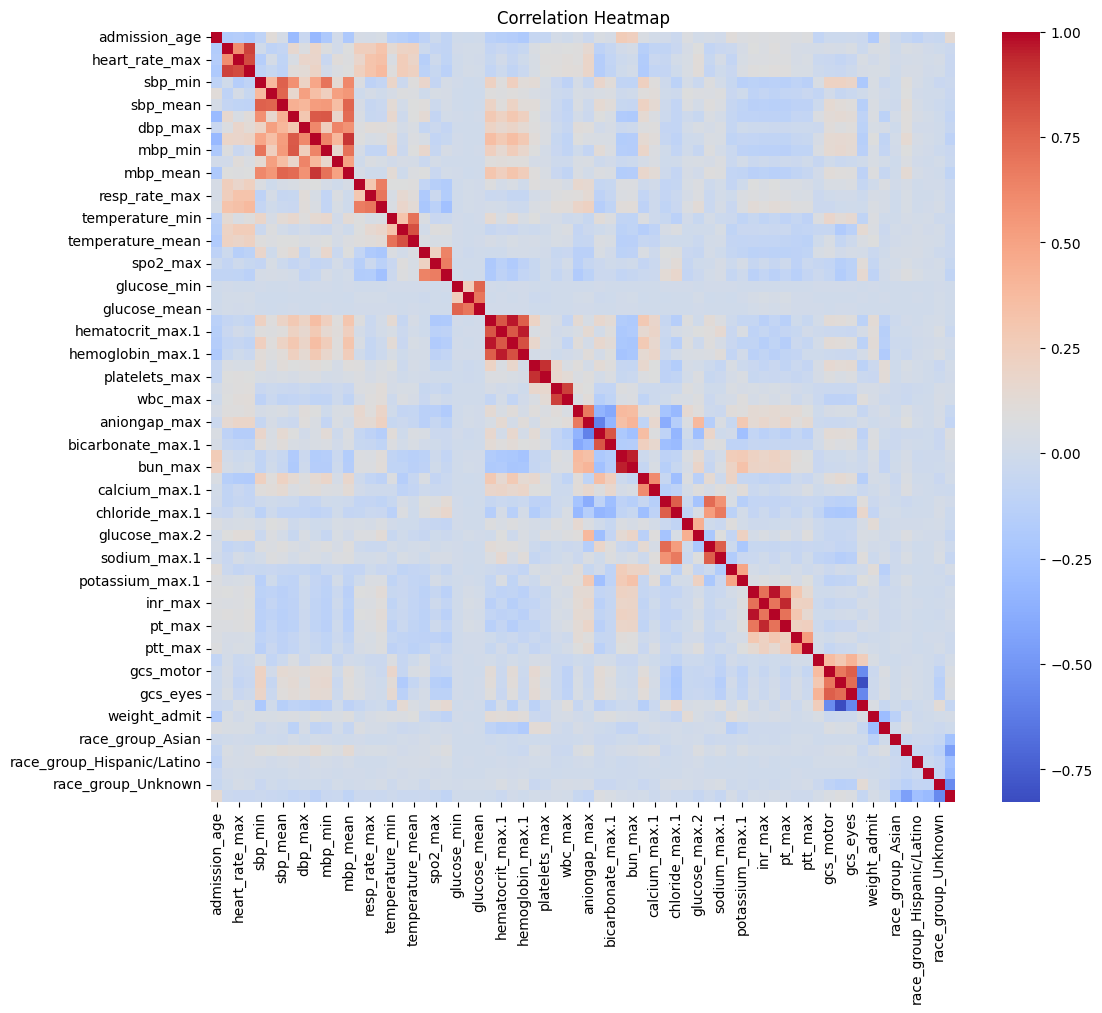

In [35]:
import seaborn as sns
corr_matrix = tmp.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm') #fmt=".2f",annot_kws={"size": 10}
plt.title('Correlation Heatmap')
plt.show()

In [36]:
corr_matrix.shape

(68, 68)

In [37]:
high_correlation = corr_matrix[(corr_matrix > 0.7) & (corr_matrix != 1.0)].stack().dropna()
print("High correlation scores (> 0.70):")
print(high_correlation)

High correlation scores (> 0.70):
heart_rate_min     heart_rate_mean      0.867750
heart_rate_max     heart_rate_mean      0.837250
heart_rate_mean    heart_rate_min       0.867750
                   heart_rate_max       0.837250
sbp_min            sbp_mean             0.768135
sbp_max            sbp_mean             0.754103
sbp_mean           sbp_min              0.768135
                   sbp_max              0.754103
                   mbp_mean             0.757317
dbp_min            dbp_mean             0.789363
                   mbp_min              0.799259
                   mbp_mean             0.734432
dbp_mean           dbp_min              0.789363
                   mbp_mean             0.905777
mbp_min            dbp_min              0.799259
                   mbp_mean             0.701016
mbp_mean           sbp_mean             0.757317
                   dbp_min              0.734432
                   dbp_mean             0.905777
                   mbp_min         

In [38]:
uncorr_features = ['admission_age','heart_rate_min', 'heart_rate_max','mbp_min', 'mbp_max',
                  'resp_rate_min', 'resp_rate_max','temperature_min', 'temperature_max',
                  'spo2_min', 'spo2_max', 'glucose_min', 'glucose_max',
                  'hemoglobin_min.1', 'hemoglobin_max.1', 'platelets_min','wbc_min',
                  'aniongap_min','bicarbonate_min.1','bun_min',  'calcium_min.1','chloride_min.1',
                  'potassium_min.1','pt_min', 'ptt_min', 'gcs_min', 'weight_admit','gender_F',
                  'race_group_Asian', 'race_group_Black/African American',
                  'race_group_Hispanic/Latino', 'race_group_Other', 'race_group_Unknown',
                  'race_group_White']

In [39]:
X_selected = X_df[uncorr_features]
X_selected

admission_age  heart_rate_min  heart_rate_max   mbp_min   mbp_max  \
0           0.868310        1.725706        0.072188 -0.297869 -1.464697   
1           0.766356        0.137659        1.539016  0.355627 -0.378206   
2           0.036513       -0.656364       -0.270072  0.646069  0.104679   
3          -0.003815       -0.722533       -0.759014  0.791290  0.144919   
4          -0.436661       -0.854870       -0.123389 -0.297869 -0.217245   
...              ...             ...             ...       ...       ...   
50915       0.069694       -1.582725        0.072188  0.355627  0.627804   
50916      -0.460133        1.593368        0.463342  0.137795 -0.861091   
50917      -0.554869       -0.127015        2.908055 -0.080037 -0.418447   
50918       0.062957       -0.788702       -1.003486  0.283016 -0.056283   
50919      -0.779258        0.931682        1.343439  0.210405  0.305881   

       resp_rate_min  resp_rate_max  temperature_min  temperature_max  \
0           0.191646      -0.559361    -5.919873e-01    -1.349661e+00   
1           1.318857       1.642855    -3.522589e-02    -4.826560e-01   
2           0.473449      -1.345867     5.215355e-01    -4.826560e-01   
3           0.473449       0.541747     7.499505e-01    -8.468645e-02   
4           1.600660       0.699048     6.785708e-01     1.407699e+00   
...              ...            ...              ...              ...   
50915      -0.935566      -1.031265    -3.492964e-01    -7.953464e-01   
50916       0.473449       0.148494     8.356061e-01     2.047293e+00   
50917       1.318857      -0.244759     1.931891e-01     5.406943e-01   
50918       0.473449       1.642855     3.615378e-02    -6.390012e-01   
50919      -1.780975       0.699048    -1.014366e-14    -1.009909e-14   

       spo2_min  ...       ptt_min   gcs_min  weight_admit  gender_F  \
0      0.642073  ... -2.202604e-01  0.491138      1.264852         1   
1     -0.120610  ... -2.380419e-01  0.491138      0.024135         1   
2      0.337000  ... -4.514195e-01  0.491138     -0.857660         1   
3     -0.425684  ... -4.425288e-01  0.491138      1.402217         1   
4     -0.273147  ... -3.002770e-01  0.491138      0.706529         0   
...         ...  ...           ...       ...           ...       ...   
50915  0.337000  ... -1.135715e-01 -0.265108      1.162936         0   
50916 -0.578220  ...  3.158624e-16  0.491138     -1.650833         1   
50917 -0.273147  ... -4.514195e-01 -4.046342     -0.064488         1   
50918  0.031926  ... -9.581916e-01  0.113015      0.604613         1   
50919  0.642073  ...  5.535246e-02  0.491138      0.396350         0   

       race_group_Asian  race_group_Black/African American  \
0                     0                                  1   
1                     0                                  0   
2                     0                                  0   
3                     0                                  0   
4                     0                                  0   
...                 ...                                ...   
50915                 0                                  0   
50916                 0                                  0   
50917                 0                                  0   
50918                 0                                  0   
50919                 0                                  0   

       race_group_Hispanic/Latino  race_group_Other  race_group_Unknown  \
0                               0                 0                   0   
1                               0                 0                   0   
2                               0                 0                   0   
3                               0                 0                   1   
4                               0                 0                   0   
...                           ...               ...                 ...   
50915                           0                 0                   0   
50916  

In [40]:
X_final = X_selected
y_final = y

In [ ]:
# Manually Doing Train-Test-HoldOut
X_nonHO, X_holdout, y_nonHO, y_holdout = train_test_split(X_final, y_final, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_nonHO, y_nonHO, test_size=0.3, random_state=42)

# Determine the number of features for the model

### Linear Method

In [ ]:
all_roc = {}
for i in range(1,len(X_final.columns)):
  model = LR() # c: 1/(strength of L1 regularization)

  print(i)
  # Forward feature selection.
  forward_selection = SFS(
      model, n_features_to_select=i, direction="forward"
  ).fit(X_train, y_train)

  model.fit(forward_selection.transform(X_train),y_train)
  y_pred_FS = model.predict_proba(forward_selection.transform(X_test))
  auroc = roc_auc_score(y_test,y_pred_FS[:,1])
  ap = average_precision_score(y_test,y_pred_FS[:,1])
  all_roc[i] = auroc
  print('Forward Selection model on train dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

1
Forward Selection model on train dataset: AUROC 0.622, AP 0.578
2
Forward Selection model on train dataset: AUROC 0.646, AP 0.612
3
Forward Selection model on train dataset: AUROC 0.665, AP 0.626
4
Forward Selection model on train dataset: AUROC 0.684, AP 0.647
5
Forward Selection model on train dataset: AUROC 0.692, AP 0.655
6
Forward Selection model on train dataset: AUROC 0.695, AP 0.660
7
Forward Selection model on train dataset: AUROC 0.698, AP 0.663
8
Forward Selection model on train dataset: AUROC 0.700, AP 0.665
9
Forward Selection model on train dataset: AUROC 0.701, AP 0.664
10
Forward Selection model on train dataset: AUROC 0.702, AP 0.666
11
Forward Selection model on train dataset: AUROC 0.704, AP 0.667
12
Forward Selection model on train dataset: AUROC 0.707, AP 0.670
13
Forward Selection model on train dataset: AUROC 0.707, AP 0.670
14
Forward Selection model on train dataset: AUROC 0.707, AP 0.670
15
Forward Selection model on train dataset: AUROC 0.710, AP 0.672
16
F

KeyboardInterrupt: 

In [ ]:
all_roc = np.fromiter(all_roc.values(), dtype=float)

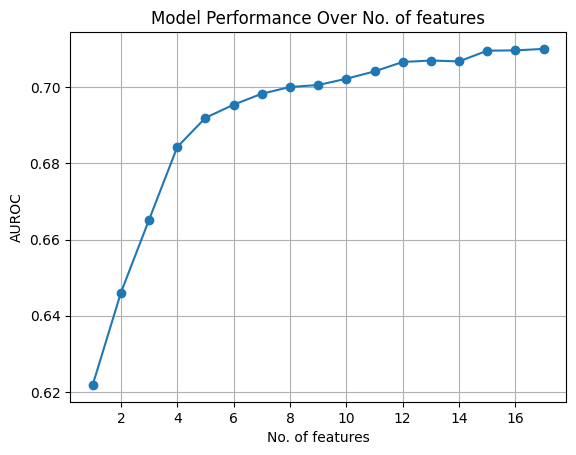

In [ ]:
import matplotlib.pyplot as plt

# Example data (iterations and corresponding AUROC values)
n_features = range(1,len(X_final.columns))  # Iteration numbers
n_features = range(1,18)  # Iteration numbers

# Plotting
plt.plot(n_features, all_roc, marker='o', linestyle='-')
plt.xlabel('No. of features')
plt.ylabel('AUROC')
plt.title('Model Performance Over No. of features')
plt.grid(True)
plt.show()

### Tree-based Method

In [ ]:
all_roc_dtc = {}
for i in range(1,len(X_final.columns)):
  dtc_model = DTC(criterion='entropy',max_depth=i)
  print(i)
  # Forward feature selection.
  forward_selection_dtc = SFS(
    dtc_model, n_features_to_select=i, direction="forward"
  ).fit(X_train, y_train)

  # Model with forward selected features
  dtc_model.fit(forward_selection_dtc.transform(X_train),y_train)
  y_pred_FS_dtc = dtc_model.predict_proba(forward_selection_dtc.transform(X_test))
  auroc = roc_auc_score(y_test,y_pred_FS_dtc[:,1])
  ap = average_precision_score(y_test,y_pred_FS_dtc[:,1])
  all_roc_dtc[i] = auroc
  print('Forward Selection model on train dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

1
Forward Selection model on train dataset: AUROC 0.592, AP 0.533
2
Forward Selection model on train dataset: AUROC 0.609, AP 0.546
3
Forward Selection model on train dataset: AUROC 0.653, AP 0.603
4
Forward Selection model on train dataset: AUROC 0.658, AP 0.609
5
Forward Selection model on train dataset: AUROC 0.663, AP 0.617
6
Forward Selection model on train dataset: AUROC 0.667, AP 0.626
7
Forward Selection model on train dataset: AUROC 0.674, AP 0.634
8
Forward Selection model on train dataset: AUROC 0.679, AP 0.633
9
Forward Selection model on train dataset: AUROC 0.674, AP 0.628
10
Forward Selection model on train dataset: AUROC 0.667, AP 0.618
11
Forward Selection model on train dataset: AUROC 0.654, AP 0.603
12
Forward Selection model on train dataset: AUROC 0.658, AP 0.604
13
Forward Selection model on train dataset: AUROC 0.638, AP 0.586
14
Forward Selection model on train dataset: AUROC 0.630, AP 0.577
15
Forward Selection model on train dataset: AUROC 0.626, AP 0.573
16
F

KeyboardInterrupt: 

In [ ]:
all_roc_dtc = np.fromiter(all_roc_dtc.values(), dtype=float)

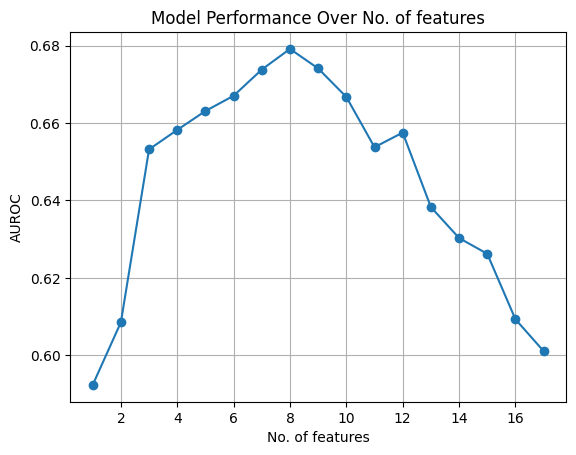

In [ ]:
# Example data (iterations and corresponding AUROC values)
n_features = range(1,18)  # Iteration numbers

# Plotting
plt.plot(n_features, all_roc_dtc, marker='o', linestyle='-')
plt.xlabel('No. of features')
plt.ylabel('AUROC')
plt.title('Model Performance Over No. of features')
plt.grid(True)
plt.show()

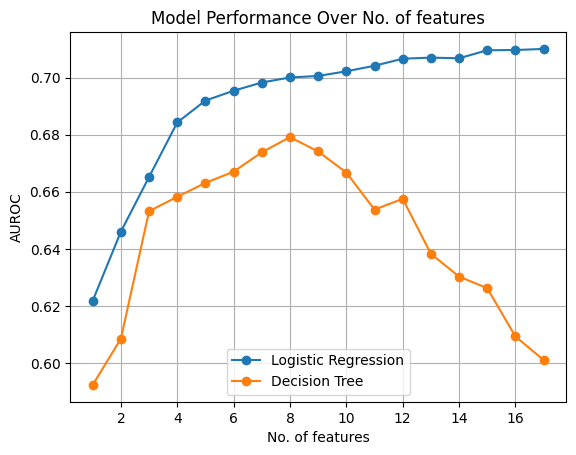

In [ ]:
# Plotting
n_features = range(1,len(X_final.columns))  # Iteration numbers
n_features = range(1,18)
plt.plot(n_features, all_roc, marker='o', linestyle='-', label = 'Logistic Regression')
plt.plot(n_features, all_roc_dtc, marker='o', linestyle='-', label = 'Decision Tree')
plt.xlabel('No. of features')
plt.ylabel('AUROC')
plt.title('Model Performance Over No. of features')
plt.grid(True)
plt.legend()
plt.show()

## Decision Tree and Forward Selection

In [ ]:
DTC_model = DTC(criterion='entropy', max_depth = 8)

# Forward feature selection.
forward_selection_dtc = SFS(
    DTC_model, n_features_to_select=8, direction="forward"
).fit(X_train, y_train)

# Full model
DTC_model.fit(X_train,y_train)
y_pred_full_dtc = DTC_model.predict_proba(X_test)
y_pred_train_full_dtc = DTC_model.predict_proba(X_train)

# Model with forward selected features
DTC_model.fit(forward_selection_dtc.transform(X_train),y_train)
y_pred_FS_dtc = DTC_model.predict_proba(forward_selection_dtc.transform(X_test))
y_pred_train_FS_dtc = DTC_model.predict_proba(forward_selection_dtc.transform(X_train))

In [ ]:
forward_selection_dtc.get_feature_names_out()

array(['admission_age', 'mbp_min', 'temperature_max', 'glucose_max',
       'wbc_min', 'bun_min', 'ptt_min', 'weight_admit'], dtype=object)

In [ ]:
forward_selection_dtc

SequentialFeatureSelector(estimator=DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=8),
                          n_features_to_select=8)

In [ ]:
auroc = roc_auc_score(y_train,y_pred_train_full_dtc[:,1])
ap = average_precision_score(y_train,y_pred_train_full_dtc[:,1])
print('Full model on train dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

auroc = roc_auc_score(y_train,y_pred_train_FS_dtc[:,1])
ap = average_precision_score(y_train,y_pred_train_FS_dtc[:,1])
print('Forward Selection model on train dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

Full model on train dataset: AUROC 0.740, AP 0.715
Forward Selection model on train dataset: AUROC 0.729, AP 0.701


In [ ]:
auroc = roc_auc_score(y_test,y_pred_full_dtc[:,1])
ap = average_precision_score(y_test,y_pred_full_dtc[:,1])
print('Full model on test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

auroc = roc_auc_score(y_test,y_pred_FS_dtc[:,1])
ap = average_precision_score(y_test,y_pred_FS_dtc[:,1])
print('Forward Selection model on test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

Full model on test dataset: AUROC 0.677, AP 0.634
Forward Selection model on test dataset: AUROC 0.679, AP 0.632


## LR and Forward Selection

In [ ]:
model = LR(penalty='l1',C=1/10,solver='liblinear') # c: 1/(strength of L1 regularization)

# Forward feature selection.
forward_selection = SFS(
    model, n_features_to_select=8, direction="forward"
).fit(X_train, y_train)

# Full model
model.fit(X_train,y_train)
y_pred_full = model.predict_proba(X_test)
y_pred_train_full = model.predict_proba(X_train)


# Model with forward selected features
model.fit(forward_selection.transform(X_train),y_train)
y_pred_FS = model.predict_proba(forward_selection.transform(X_test))
y_pred_train_FS = model.predict_proba(forward_selection.transform(X_train))

In [ ]:
y_pred_FS

array([[0.6930804 , 0.3069196 ],
       [0.51412473, 0.48587527],
       [0.6234371 , 0.3765629 ],
       ...,
       [0.6434691 , 0.3565309 ],
       [0.85660608, 0.14339392],
       [0.56150738, 0.43849262]])

In [ ]:
forward_selection.get_feature_names_out()

array(['admission_age', 'heart_rate_max', 'mbp_min', 'spo2_max',
       'bicarbonate_min.1', 'bun_min', 'gcs_min', 'weight_admit'],
      dtype=object)

In [ ]:
auroc = roc_auc_score(y_train,y_pred_train_full[:,1])
ap = average_precision_score(y_train,y_pred_train_full[:,1])
print('Full model on train dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

auroc = roc_auc_score(y_train,y_pred_train_FS[:,1])
ap = average_precision_score(y_train,y_pred_train_FS[:,1])
print('Forward Selection model on train dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

Full model on train dataset: AUROC 0.720, AP 0.682
Forward Selection model on train dataset: AUROC 0.705, AP 0.666


In [ ]:
auroc = roc_auc_score(y_test,y_pred_full[:,1])
ap = average_precision_score(y_test,y_pred_full[:,1])
print('Full model on test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

auroc = roc_auc_score(y_test,y_pred_FS[:,1])
ap = average_precision_score(y_test,y_pred_FS[:,1])
print('Forward Selection model on test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

Full model on test dataset: AUROC 0.716, AP 0.681
Forward Selection model on test dataset: AUROC 0.701, AP 0.666


## Select K Best

(50552, 8)


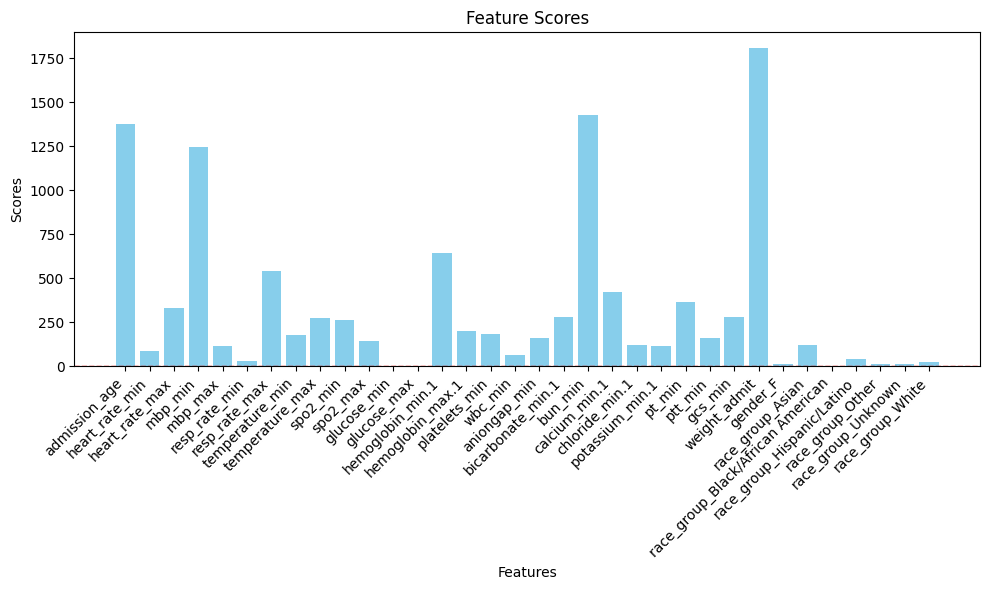

In [ ]:
# Feature Selection Method 3: Select K Best
# define feature selection
np.random.seed(42)
fs = SelectKBest(k=8) #

# apply feature selection
X_kbest = fs.fit_transform(X_final, y)
print(X_kbest.shape)
# Example data (replace this with your actual data)
feature_names = X_final.columns
scores = fs.scores_

plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.bar(feature_names, scores, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Scores')
plt.title('Feature Scores')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.axhline(y=0.01, color='r', linestyle='--', linewidth=1)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
X_final.columns[fs.get_support()]

Index(['admission_age', 'mbp_min', 'resp_rate_max', 'hemoglobin_min.1',
       'bun_min', 'calcium_min.1', 'pt_min', 'weight_admit'],
      dtype='object')

## Model Selection

In [ ]:
X_allfeature = X_final

In [41]:
features = ['admission_age', 'mbp_min', 'bun_min',  'weight_admit']

In [42]:
# Manually Doing Train-Test-HoldOut
X_final = X_final.loc[:,features]
X_nonHO, X_holdout, y_nonHO, y_holdout = train_test_split(X_final, y_final, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_nonHO, y_nonHO, test_size=0.3, random_state=42)

In [ ]:
Xy = pd.concat([X_final,y_final],axis=1)
Xy['label'] = np.where(Xy['aki'].to_numpy()==0,'Less Severe','Severe')
Xy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50552 entries, 0 to 50919
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   admission_age  50552 non-null  float64
 1   mbp_min        50552 non-null  float64
 2   bun_min        50552 non-null  float64
 3   weight_admit   50552 non-null  float64
 4   aki            50552 non-null  int64  
 5   label          50552 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 2.7+ MB


In [ ]:
# Plotly plotting package
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
fig = px.scatter_3d(
    Xy,
    z='bun_min',
    y='mbp_min',
    x='weight_admit',
    color='label'
)

fig.update_traces(
    marker={'size':2.5}
)

surface_z = [[0.052,0.052],[0.052,0.052]]
surface_y = [0.1,2.7]
surface_x = [0,0.29]

fig.add_trace(
    go.Surface(
        x=surface_x,
        y=surface_y,
        z=surface_z,
        opacity=0.5,
        showscale=False,
        colorscale='greys',
        name='separating hyperplane',
        showlegend=True,
        visible='legendonly'
    )
)

fig

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Initialize the model you want to evaluate
linear_models = {
    'LRL1':LR(penalty='l1', solver = 'liblinear'),
    'LRL2':LR(penalty='l2'),
    'SVCM':SVC(kernel='linear')
}

# Define the number of folds for cross-validation
k_folds = 8

# Initialize KFold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for model in linear_models:
    cv_results = cross_val_score(linear_models[model], X_nonHO, y_nonHO, cv=kfold,scoring='roc_auc')
    print("Current model:", model)
    # Print the cross-validation results
    print("Cross-validation results:", cv_results)
    print("Mean AUROC:", cv_results.mean())


Current model: LRL1
Cross-validation results: [0.68650411 0.68776438 0.68192717 0.68398823 0.6911826  0.6804047
 0.69082583 0.67969257]
Mean AUROC: 0.6852861978804896
Current model: LRL2
Cross-validation results: [0.68650596 0.68776326 0.68192617 0.68398699 0.69118086 0.68040482
 0.69082373 0.67969195]
Mean AUROC: 0.6852854692135313
Current model: SVCM
Cross-validation results: [0.6879062  0.68909784 0.68173617 0.68438133 0.6922169  0.68111404
 0.69088583 0.6800927 ]
Mean AUROC: 0.6859288754480575


In [64]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Initialize the model you want to evaluate
linear_models = {
    'LRL1':LR(penalty='l1', solver = 'liblinear'),
    'LRL2':LR(penalty='l2'),
    'SVCM':SVC(kernel='linear')
}

# Define the number of folds for cross-validation
k_folds = 8

# Initialize KFold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for model in linear_models:
    cv_results = cross_val_score(linear_models[model], X_nonHO, y_nonHO, cv=kfold,scoring='f1')
    print("Current model:", model)
    # Print the cross-validation results
    print("Cross-validation results:", cv_results)
    print("Mean F1:", cv_results.mean())


Current model: LRL1
Cross-validation results: [0.60519731 0.59162    0.59318716 0.59330331 0.60693642 0.596139
 0.60120552 0.58816591]
Mean AUROC: 0.5969693278813863
Current model: LRL2
Cross-validation results: [0.60519731 0.59173426 0.59318716 0.59330331 0.60693642 0.596139
 0.60120552 0.58816591]
Mean AUROC: 0.5969836099401895
Current model: SVCM
Cross-validation results: [0.60245184 0.58920188 0.58693069 0.58683584 0.59910174 0.59376218
 0.59752017 0.58447489]
Mean AUROC: 0.5925349043334024


In [ ]:
# Initialize the model you want to evaluate
nonlinear_models = {
    'DecisionTree':DTC(criterion='entropy'),
    'RandomForest':RFC(),
    'AdaBoost':AdaBoost(),
    'GDBoost':GDBoost(),
    'XGBoost':XGBC(),
    'SVM_rbf':SVC(kernel='rbf')
}

# Define the number of folds for cross-validation
k_folds = 8

# Initialize KFold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for model in nonlinear_models:
    cv_results = cross_val_score(nonlinear_models[model], X_nonHO, y_nonHO, cv=kfold,scoring='roc_auc')
    print("Current model:", model)
    # Print the cross-validation results
    print("Cross-validation results:", cv_results)
    print("Mean AUROC:", cv_results.mean())

Current model: DecisionTree
Cross-validation results: [0.55313486 0.55180481 0.55890863 0.55871354 0.56520498 0.55591374
 0.56136357 0.54962677]
Mean AUROC: 0.5568338628706699
Current model: RandomForest
Cross-validation results: [0.65615946 0.65068296 0.65603183 0.65159964 0.66208088 0.65280671
 0.66801649 0.64562402]
Mean AUROC: 0.655375248265955
Current model: AdaBoost
Cross-validation results: [0.68547504 0.68871685 0.68441456 0.68917462 0.6908973  0.68597986
 0.69226523 0.68227737]
Mean AUROC: 0.687400102542925
Current model: GDBoost
Cross-validation results: [0.69185368 0.69553452 0.6908507  0.69599592 0.70027714 0.6904031
 0.69755105 0.68806479]
Mean AUROC: 0.6938163612906549
Current model: XGBoost
Cross-validation results: [0.67554896 0.67896979 0.67369124 0.68046991 0.680258   0.67315107
 0.67812207 0.67582833]
Mean AUROC: 0.6770049204663674
Current model: SVM_rbf
Cross-validation results: [0.68816066 0.68927124 0.68220226 0.68457081 0.69251248 0.68030986
 0.69214969 0.6794795

In [65]:
# Initialize the model you want to evaluate
nonlinear_models = {
    'DecisionTree':DTC(criterion='entropy'),
    'RandomForest':RFC(),
    'AdaBoost':AdaBoost(),
    'GDBoost':GDBoost(),
    'XGBoost':XGBC(),
    'SVM_rbf':SVC(kernel='rbf')
}

# Define the number of folds for cross-validation
k_folds = 8

# Initialize KFold cross-validator
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

for model in nonlinear_models:
    cv_results = cross_val_score(nonlinear_models[model], X_nonHO, y_nonHO, cv=kfold,scoring='f1')
    print("Current model:", model)
    # Print the cross-validation results
    print("Cross-validation results:", cv_results)
    print("Mean F1:", cv_results.mean())


Current model: DecisionTree
Cross-validation results: [0.54029471 0.53188352 0.54278369 0.53109244 0.53454681 0.5390726
 0.54248609 0.52146323]
Mean F1: 0.5354528859552379
Current model: RandomForest
Cross-validation results: [0.59423256 0.57321462 0.57643072 0.57963247 0.58612891 0.58548539
 0.58392209 0.57512855]
Mean F1: 0.5817719140136031
Current model: AdaBoost
Cross-validation results: [0.60514776 0.59716178 0.59911894 0.60710195 0.61034287 0.60759494
 0.61512287 0.59259259]
Mean F1: 0.6042729623805201
Current model: GDBoost
Cross-validation results: [0.60967379 0.60903955 0.60367253 0.60902831 0.62155009 0.62010859
 0.61739625 0.60054033]
Mean F1: 0.611376181077663
Current model: XGBoost
Cross-validation results: [0.59786477 0.60120846 0.5978364  0.60788421 0.60639304 0.5959615
 0.59874549 0.59827751]
Mean F1: 0.6005214226668671
Current model: SVM_rbf
Cross-validation results: [0.61321287 0.60625715 0.60816012 0.61271676 0.6158525  0.60600304
 0.61942157 0.59791022]
Mean F1: 0.6

## Hyper Parameter Tuning

In [43]:
Xy = pd.concat([X_final,y_final],axis=1)
Xy['aki'] = np.where(Xy['aki'].to_numpy()==0,False,True)
Xy.info
Xy_test = pd.concat([X_test,y_test],axis=1)
Xy_test['aki'] = Xy_test['aki'].astype(str)
Xy_train = pd.concat([X_train,y_train],axis=1)
Xy_train['aki'] = Xy_train['aki'].astype(str)

In [ ]:
'''
linear_features = ['admission_age', 'heart_rate_max', 'mbp_min', 'spo2_max',
       'bicarbonate_min.1', 'bun_min', 'gcs_min', 'weight_admit']
nonlinear_features = ['admission_age', 'mbp_min', 'resp_rate_min', 'temperature_max',
       'glucose_max', 'bun_min', 'ptt_min', 'weight_admit']

X_linear_nonHO = X_nonHO.loc[:,linear_features]
X_nonlinear_nonHO = X_nonHO.loc[:,nonlinear_features]
'''

In [48]:
stratifiedCV = StratifiedKFold(n_splits=8)
BestParams_linear = GridSearchCV(
        LR(penalty='l1', solver = 'liblinear'),
        #SVC(kernel='linear'),
        param_grid = {'C':np.arange(start=1,stop=20,step=5)},
        scoring='roc_auc',#'f1',
        cv=stratifiedCV,
        n_jobs=-1
    )
BestParams_linear.fit(X_nonHO ,y_nonHO)
print('For LR cross validation AUC score is {:.7f}'.format(BestParams_linear.best_score_))

For LR cross validation AUC score is 0.6854315


In [49]:
print(BestParams_linear.best_estimator_)

LogisticRegression(C=6, penalty='l1', solver='liblinear')


In [ ]:
stratifiedCV = StratifiedKFold(n_splits=8)
BestParams_linear_svm = GridSearchCV(
        #LR(penalty='l2'),
        SVC(kernel='linear'),
        param_grid = {'C':np.arange(start=1,stop=20,step=5)},
        scoring='roc_auc',#'f1',
        cv=stratifiedCV,
        n_jobs=-1
    )
BestParams_linear_svm.fit(X_nonHO ,y_nonHO)
print('For SVCM cross validation AUC score is {:.7f}'.format(BestParams_linear_svm.best_score_))

For LR cross validation AUC score is 0.6861225


In [ ]:
print(BestParams_linear_svm.best_estimator_)

SVC(C=6, kernel='linear')


In [50]:
stratifiedCV = StratifiedKFold(n_splits=8)
BestParams_nonlinear = GridSearchCV(
        GDBoost(),
        param_grid = {
        'n_estimators':np.arange(start=80,stop=120,step=20),
        'max_depth':np.arange(start=2,stop=6),
        'learning_rate':np.arange(start=0.05,stop=0.4,step=0.05)
        },
        scoring='roc_auc',#'f1',
        cv=stratifiedCV,
        n_jobs=-1
    )
BestParams_nonlinear.fit(X_nonHO ,y_nonHO)
print('For GDBoost cross validation roc_auc score is {:.7f}'.format(BestParams_nonlinear.best_score_))

For GDBoost cross validation roc_auc score is 0.6940383


In [51]:
print(BestParams_nonlinear.best_estimator_)

GradientBoostingClassifier(learning_rate=0.05, max_depth=4)


In [ ]:
y_pred_linear = BestParams_linear.predict_proba(X_holdout)
#y_pred_linear_svm = BestParams_linear_svm.predict_proba(X_test)
y_pred_nonlinear = BestParams_nonlinear.predict_proba(X_holdout)

In [ ]:
# roc_curve
fpr_LRL1, tpr_LRL1, _ = roc_curve(y_holdout,y_pred_linear[:,1])
fpr_LRL2, tpr_LRL2, _ = roc_curve(y_holdout,y_pred_nonlinear[:,1])

roc_df = pd.DataFrame(
    {
        'False Positive Rate':np.hstack([fpr_LRL1,fpr_LRL2]),
        'True Positive Rate':np.hstack([tpr_LRL1,tpr_LRL2]),
        'method':['Linear']*len(fpr_LRL1)+['Non-Linear']*len(fpr_LRL2)
    }
)
# Visualize ROC curve
fig = px.line(roc_df,y='True Positive Rate',x='False Positive Rate',facet_col='method',color='method')
fig

In [ ]:
# precision recall curves
p_LRL1, r_LRL1, _ = precision_recall_curve(y_holdout,y_pred_linear[:,1])
p_LRL2, r_LRL2, _ = precision_recall_curve(y_holdout,y_pred_nonlinear[:,1])

pr_df = pd.DataFrame(
    {
        'Precision':np.hstack([p_LRL1,p_LRL2]),
        'Recall':np.hstack([r_LRL1,r_LRL2]),
        'method':['Linear']*len(p_LRL1)+['Non-Linear']*len(p_LRL2)
    }
)

# Visualize precision recall curve
fig = px.line(pr_df,x='Recall',y='Precision',facet_col='method',color='method')
fig

In [ ]:
BestParams_linear.predict

array([[0.42711476, 0.57288524],
       [0.22732154, 0.77267846],
       [0.50259365, 0.49740635],
       ...,
       [0.57165492, 0.42834508],
       [0.60365469, 0.39634531],
       [0.35400316, 0.64599684]])

In [66]:
print('Linear Model:')
y_pred_linear_nonHO = BestParams_linear.predict(X_nonHO)
print('F1 score on train set: {:.7f}'.format(f1_score(y_nonHO,y_pred_linear_nonHO)))
auroc = roc_auc_score(y_nonHO,y_pred_linear_nonHO)
ap = average_precision_score(y_nonHO,y_pred_linear_nonHO)
accuracy = accuracy_score(y_nonHO, y_pred_linear_nonHO)
print('Best Model on train dataset: AUROC {:.7f}, AP {:.7f}, Accuracy {:.7f}'.format(auroc,ap,accuracy))
pd.crosstab(y_nonHO,y_pred_linear_nonHO)

Linear Model:
F1 score on train set: 0.5974808
Best Model on train dataset: AUROC 0.6323797, AP 0.5632013, Accuracy 0.6354625


col_0      0      1
aki                
0      16602   7245
1       9340  12309

In [67]:
print('Non-Linear Model:')
y_pred_nonlinear_nonHO = BestParams_nonlinear.predict(X_nonHO)
print('F1 score on train set: {:.7f}'.format(f1_score(y_nonHO,y_pred_nonlinear_nonHO)))
auroc = roc_auc_score(y_nonHO,y_pred_nonlinear_nonHO)
ap = average_precision_score(y_nonHO,y_pred_nonlinear_nonHO)
accuracy = accuracy_score(y_nonHO, y_pred_nonlinear_nonHO)
print('Best Model on train dataset: AUROC {:.7f}, AP {:.7f}, Accuracy {:.7f}'.format(auroc,ap,accuracy))
pd.crosstab(y_nonHO,y_pred_nonlinear_nonHO)


Non-Linear Model:
F1 score on train set: 0.6278906
Best Model on train dataset: AUROC 0.6503612, AP 0.5765816, Accuracy 0.6519694


col_0      0      1
aki                
0      16303   7544
1       8290  13359

## Ensemble Model

In [54]:
print('Linear Model:')
y_pred_linear_HO = BestParams_linear.predict(X_holdout)
print('F1 score on validation dataset: {:.7f}'.format(f1_score(y_holdout,y_pred_linear_HO)))
auroc = roc_auc_score(y_holdout,y_pred_linear_HO)
ap = average_precision_score(y_holdout,y_pred_linear_HO)
accuracy = accuracy_score(y_holdout, y_pred_linear_HO)
print('Best Model on validation dataset: AUROC {:.7f}, AP {:.7f}, Accuracy {:.7f}'.format(auroc,ap,accuracy))
pd.crosstab(y_holdout,y_pred_linear_HO)

Linear Model:
F1 score on validation dataset: 0.6064844
Best Model on validation dataset: AUROC 0.6318357, AP 0.5781910, Accuracy 0.6327136


col_0     0     1
aki              
0      1768   799
1      1058  1431

In [55]:
print('Non-Linear Model:')
y_pred_nonlinear_HO = BestParams_nonlinear.predict(X_holdout)
print('F1 score on validation set: {:.7f}'.format(f1_score(y_holdout,y_pred_nonlinear_HO)))
auroc = roc_auc_score(y_holdout,y_pred_nonlinear_HO)
ap = average_precision_score(y_holdout,y_pred_nonlinear_HO)
accuracy = accuracy_score(y_holdout, y_pred_nonlinear_HO)
print('Best Model on validation dataset: AUROC {:.7f}, AP {:.7f}, Accuracy {:.7f}'.format(auroc,ap,accuracy))
pd.crosstab(y_holdout,y_pred_nonlinear_HO)

Non-Linear Model:
F1 score on validation set: 0.6221208
Best Model on validation dataset: AUROC 0.6392629, AP 0.5832630, Accuracy 0.6398339


col_0     0     1
aki              
0      1736   831
1       990  1499

In [56]:
from sklearn.ensemble import VotingClassifier

In [57]:
# Create an ensemble model
ensemble_model1 = VotingClassifier(estimators=[
    ('Linear Best', BestParams_linear),
    ('Non-linear Best', BestParams_nonlinear)
], voting='soft')
# Train the ensemble model
ensemble_model1.fit(X_train, y_train)
# Predictions
y_pred_ensemble_test = ensemble_model1.predict(X_test)
auroc = roc_auc_score(y_test, y_pred_ensemble_test)
print("AUROC of Ensemble Model:", auroc)

AUROC of Ensemble Model: 0.6369509596469789


In [73]:
print('Ensemble Model:')
y_pred_ens_nonHO = ensemble_model1.predict(X_nonHO)
print('F1 score on train set: {:.7f}'.format(f1_score(y_nonHO,y_pred_ens_nonHO)))
auroc = roc_auc_score(y_nonHO,y_pred_ens_nonHO)
ap = average_precision_score(y_nonHO,y_pred_ens_nonHO)
accuracy = accuracy_score(y_nonHO, y_pred_ens_nonHO)
print('Best Model on train dataset: AUROC {:.7f}, AP {:.7f}, Accuracy {:.7f}'.format(auroc,ap,accuracy))
pd.crosstab(y_nonHO,y_pred_ens_nonHO)

Ensemble Model:
F1 score on train set: 0.6109434
Best Model on train dataset: AUROC 0.6405543, AP 0.5693489, Accuracy 0.6430455


col_0      0      1
aki                
0      16505   7342
1       8898  12751

In [58]:
print('Ensemble Model:')
y_pred_ens_HO = ensemble_model1.predict(X_holdout)
print('F1 score on validation set: {:.7f}'.format(f1_score(y_holdout,y_pred_ens_HO)))
auroc = roc_auc_score(y_holdout,y_pred_ens_HO)
ap = average_precision_score(y_holdout,y_pred_ens_HO)
accuracy = accuracy_score(y_holdout, y_pred_ens_HO)
print('Best Model on validation dataset: AUROC {:.7f}, AP {:.7f}, Accuracy {:.7f}'.format(auroc,ap,accuracy))
pd.crosstab(y_holdout,y_pred_ens_HO)

Ensemble Model:
F1 score on validation set: 0.6165445
Best Model on validation dataset: AUROC 0.6371502, AP 0.5819625, Accuracy 0.6378560


col_0     0     1
aki              
0      1753   814
1      1017  1472

In [69]:
# Create an ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('Linear Best', BestParams_linear),
    ('Non-linear Best', BestParams_nonlinear),
    ('AdaBoost',nonlinear_models['AdaBoost']),
    #('SVM_rbf',nonlinear_models['SVM_rbf'])
], voting='soft')
# Train the ensemble model
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict_proba(X_test)
print('Ensemble Model:')
y_pred_ens_HO = ensemble_model.predict(X_holdout)
print('F1 score on validation set: {:.7f}'.format(f1_score(y_holdout,y_pred_ens_HO)))
auroc = roc_auc_score(y_holdout,y_pred_ens_HO)
ap = average_precision_score(y_holdout,y_pred_ens_HO)
accuracy = accuracy_score(y_holdout, y_pred_ens_HO)
print('Best Model on validation dataset: AUROC {:.7f}, AP {:.7f}, Accuracy {:.7f}'.format(auroc,ap,accuracy))
pd.crosstab(y_holdout,y_pred_ens_HO)


Ensemble Model:
F1 score on validation set: 0.6165445
Best Model on validation dataset: AUROC 0.6371502, AP 0.5819625, Accuracy 0.6378560


col_0     0     1
aki              
0      1753   814
1      1017  1472

In [59]:
y_pred_linear_HO = BestParams_linear.predict_proba(X_holdout)
y_pred_nonlinear_HO = BestParams_nonlinear.predict_proba(X_holdout)
y_pred_ens1_HO = ensemble_model1.predict_proba(X_holdout)
#y_pred_ens_HO = ensemble_model.predict_proba(X_holdout)

In [70]:
# roc_curve
fpr_linear, tpr_linear, _ = roc_curve(y_holdout,y_pred_linear_HO[:,1])
fpr_nonlinear, tpr_nonlinear, _ = roc_curve(y_holdout,y_pred_nonlinear_HO[:,1])
fpr_ens1, tpr_lens1, _ = roc_curve(y_holdout,y_pred_ens1_HO[:,1])
#fpr_ens, tpr_ens, _ = roc_curve(y_holdout,y_pred_ens_HO)

roc_df = pd.DataFrame(
    {
        'False Positive Rate':np.hstack([fpr_linear,fpr_nonlinear,fpr_ens1]),
        'True Positive Rate':np.hstack([tpr_linear, tpr_nonlinear, tpr_lens1]),
        'method':['Linear']*len(fpr_linear)+['Non-Linear']*len(fpr_nonlinear)
        +['Ensemble']*len(fpr_ens1)#+['Ensemble of 5']*len(fpr_ens)
    }
)
# Visualize ROC curve
fig = px.line(roc_df,y='True Positive Rate',x='False Positive Rate',color='method')
fig

In [71]:
# precision recall curves
p_linear, r_linear, _ = precision_recall_curve(y_holdout,y_pred_linear_HO[:,1])
p_nonlinear, r_nonlinear, _ = precision_recall_curve(y_holdout,y_pred_nonlinear_HO[:,1])
p_ens1, r_lens1, _ = precision_recall_curve(y_holdout,y_pred_ens1_HO[:,1])
pr_df = pd.DataFrame(
    {
        'Precision':np.hstack([p_linear,p_nonlinear,p_ens1]),
        'Recall':np.hstack([r_linear,r_nonlinear,r_lens1]),
        'method':['Linear']*len(p_linear)+['Non-Linear']*len(p_nonlinear) + ['Ensemble']*len(p_ens1)
    }
)

# Visualize precision recall curve
fig = px.line(pr_df,x='Recall',y='Precision',color='method')#facet_col='method',
fig

# Archive Code. Not Used.

## XGBoost and Forward Selection

In [ ]:
xgb_model = XGBC()

# Forward feature selection.
forward_selection_xgb = SFS(
    xgb_model, n_features_to_select=8, direction="forward"
).fit(X_train, y_train)

# Full model
xgb_model.fit(X_train,y_train)
y_pred_full_xgb = xgb_model.predict_proba(X_test)
y_pred_train_full_xgb = xgb_model.predict_proba(X_train)

# Model with forward selected features
xgb_model.fit(forward_selection_xgb.transform(X_train),y_train)
y_pred_FS_xgb = xgb_model.predict_proba(forward_selection_xgb.transform(X_test))
y_pred_train_FS_xgb = xgb_model.predict_proba(forward_selection_xgb.transform(X_train))

In [ ]:
forward_selection_xgb.get_feature_names_out()

array(['admission_age', 'temperature_min', 'temperature_max',
       'bicarbonate_min.1', 'bun_min', 'calcium_min.1', 'pt_min',
       'weight_admit'], dtype=object)

In [ ]:
# roc_curve
fpr_full, tpr_full, _ = roc_curve(y_test,y_pred_full_xgb[:,1])
fpr_FS, tpr_FS, _ = roc_curve(y_test,y_pred_FS_xgb[:,1])

roc_df = pd.DataFrame(
    {
        'False Positive Rate':np.hstack([fpr_full,fpr_FS]),
        'True Positive Rate':np.hstack([tpr_full,tpr_FS]),
        'method':['full_model']*len(fpr_full)+['FS']*len(fpr_FS)
    }
)
# Visualize ROC curve
fig = px.line(roc_df,y='True Positive Rate',x='False Positive Rate',facet_col='method',color='method')
fig

In [ ]:
# precision recall curves
p_full, r_full, _ = precision_recall_curve(y_test,y_pred_full_xgb[:,1])
p_FS, r_FS, _ = precision_recall_curve(y_test,y_pred_FS_xgb[:,1])

pr_df = pd.DataFrame(
    {
        'Precision':np.hstack([p_full,p_FS]),
        'Recall':np.hstack([r_full,r_FS]),
        'method':['Full Model']*len(p_full)+['Forward Selection']*len(p_FS)
    }
)
# Visualize precision recall curve
fig = px.line(pr_df,x='Recall',y='Precision',facet_col='method',color='method')
fig

In [ ]:
auroc = roc_auc_score(y_train,y_pred_train_full_xgb[:,1])
ap = average_precision_score(y_train,y_pred_train_full_xgb[:,1])
print('Full model on train dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

auroc = roc_auc_score(y_train,y_pred_train_FS_xgb[:,1])
ap = average_precision_score(y_train,y_pred_train_FS_xgb[:,1])
print('Forward Selection model on train dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

Full model on train dataset: AUROC 0.920, AP 0.919
Forward Selection model on train dataset: AUROC 0.847, AP 0.845


In [ ]:
auroc = roc_auc_score(y_test,y_pred_full_xgb[:,1])
ap = average_precision_score(y_test,y_pred_full_xgb[:,1])
print('Full model on test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

auroc = roc_auc_score(y_test,y_pred_FS_xgb[:,1])
ap = average_precision_score(y_test,y_pred_FS_xgb[:,1])
print('Forward Selection model on test dataset: AUROC {:.3f}, AP {:.3f}'.format(auroc,ap))

Full model on test dataset: AUROC 0.724, AP 0.699
Forward Selection model on test dataset: AUROC 0.696, AP 0.663


## Select down to 8

(50552, 8)


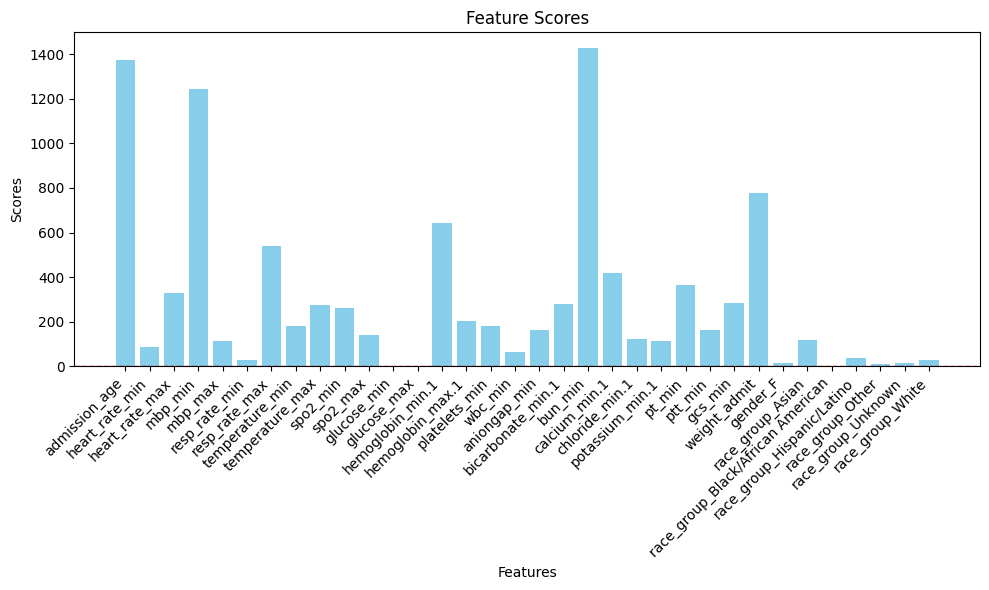

In [ ]:
# Feature Selection Method 3: Select K Best
# define feature selection
np.random.seed(42)
fs = SelectKBest(k=8) #

# apply feature selection
X_kbest = fs.fit_transform(X_final, y)
print(X_kbest.shape)
# Example data (replace this with your actual data)
feature_names = X_final.columns
scores = fs.scores_

plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.bar(feature_names, scores, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Scores')
plt.title('Feature Scores')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.axhline(y=0.01, color='r', linestyle='--', linewidth=1)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
X_final.columns[fs.get_support()]

Index(['admission_age', 'mbp_min', 'resp_rate_max', 'hemoglobin_min.1',
       'bun_min', 'calcium_min.1', 'pt_min', 'weight_admit'],
      dtype='object')

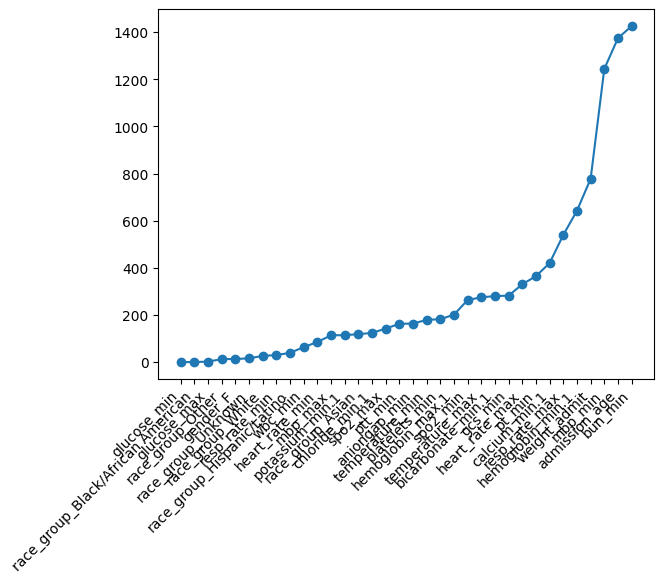

In [ ]:
sorted_indices = np.argsort(scores)
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_scores = [scores[i] for i in sorted_indices]

# Plotting
plt.plot(sorted_feature_names, sorted_scores, marker='o', linestyle='-')

# Tilt x-axis labels to 45 degrees
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()

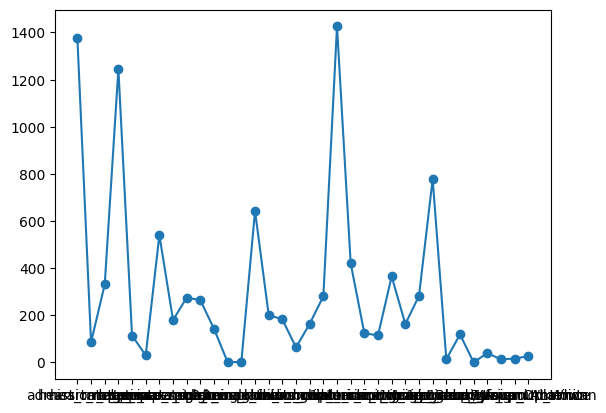

In [ ]:
plt.plot(feature_names, scores, marker='o', linestyle='-')

In [ ]:
# Feature Selection Method 3: Select K Best
# define feature selection
np.random.seed(42)
fs = SelectKBest(score_func=mutual_info_classif) #f_classif

# apply feature selection
X_kbest = fs.fit_transform(X_selected, y)
print(X_kbest.shape)

(50552, 10)


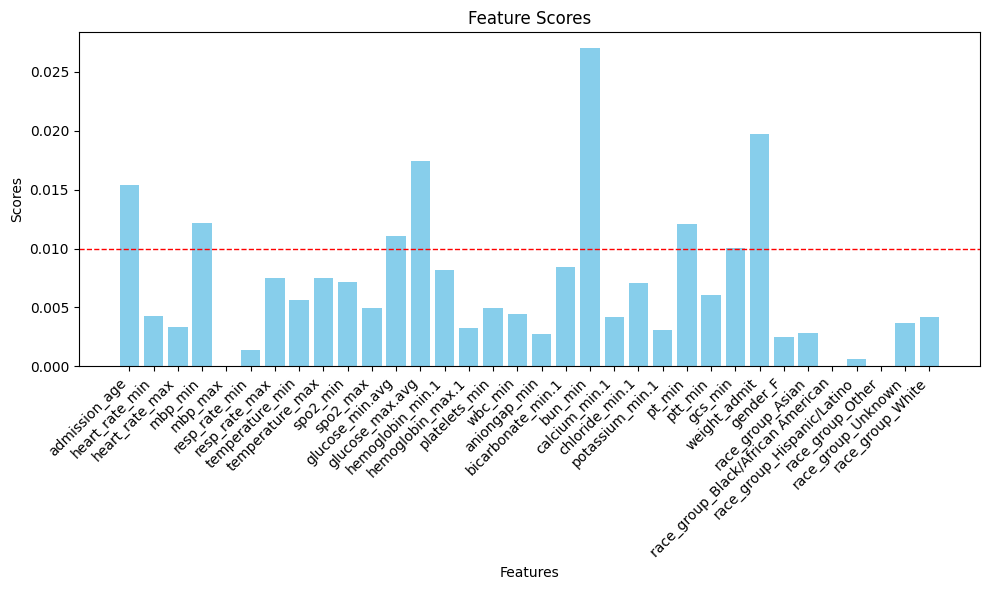

In [ ]:
# Example data (replace this with your actual data)
feature_names = X_selected.columns
scores = fs.scores_

plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.bar(feature_names, scores, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Scores')
plt.title('Feature Scores')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.axhline(y=0.01, color='r', linestyle='--', linewidth=1)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
# top k=10 features
X_selected.columns[fs.get_support()]

# top feature that pass the threshold score
X_selected.columns[fs.scores_>0.01]

X_final = X_selected.loc[:,X_selected.columns[fs.scores_>0.01]]
y_final = y